# <center> Butter-E Dataset Notebooks: Caching Analysis </center>
---

This notebook contains the code to produce the caching analysis figures of the butter_e dataset.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import scipy
import scipy.interpolate

from pprint import pprint
from pandas.api.types import is_numeric_dtype

from common import *

/home/ctripp/gcomp/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load data

In [2]:
experiments = pd.read_parquet("data_artifacts/experiments.pq")

In [3]:
working_sets = ["parameter", "parameter2x", "parameter2x_dataset", "bwd_layer"]
pprint([c for c in experiments.columns if "ws" in c])

[]


In [4]:
def compute_quantiles(interpolation_x, x, y, window_size, min_window_population=50):
    def compute_quantiles_for_value(x_value):
        deltas = np.abs(x - float(x_value))
        window_mask = deltas <= window_size
        window = y.loc[window_mask].to_numpy()
        if len(window) < min_window_population:
            return np.array([np.nan] * 4)
        v = [x_value] + np.quantile(window, [0.25, 0.5, 0.75]).tolist()
        return v

    quantile_data = [
        value
        for value in (
            compute_quantiles_for_value(x_value) for x_value in interpolation_x
        )
        if not pd.isna(value[0])
    ]
    quantiles = np.fromiter(
        quantile_data,
        dtype=np.dtype((np.float32, 4)),
        count=len(quantile_data),
    )
    return quantiles


def compute_moving_average(x, window_size=1):
    def func(i):
        window = x[max(0, i - window_size) : min(x.shape[0], i + window_size)]
        return np.average(window)

    return np.fromiter((func(i) for i in range(x.shape[0])), dtype=np.float32)


def compute_moving_averages_of_windowed_quantiles(
    x,
    y,
    resolution=500,
    min_window_population=50,
    quantile_window_size=0.5,
    moving_average_window_size=None,
):
    print(f"{x.min()} {x.max()} {resolution}")
    interpolation_stepsize = (x.max() - x.min()) / (resolution - 1)
    interpolation_x = np.arange(x.min(), x.max(), interpolation_stepsize)
    if moving_average_window_size is None:
        moving_average_window_size = int(
            np.round(quantile_window_size / interpolation_stepsize)
        )
    quantiles = compute_quantiles(
        interpolation_x, x, y, quantile_window_size, min_window_population
    )
    for i in range(1, 4):
        quantiles[:, i] = compute_moving_average(
            quantiles[:, i], moving_average_window_size
        )
    return quantiles

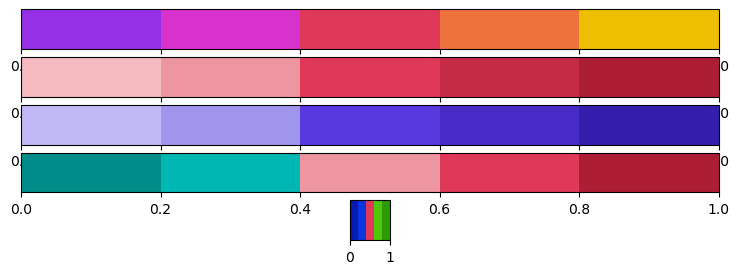

In [5]:
import pylab as pl

fig, axs = plt.subplots(len(pallette), 1, figsize=(9, 3))
for i, (ax, p) in enumerate(zip(axs, pallette)):
    cmap = mpl.colors.LinearSegmentedColormap.from_list(f"pal{i}", p, N=len(p))
    img = pl.imshow(np.array([[0, 1]]), cmap=cmap)
    # cax = pl.axes([0.1, 0.2, 0.8, 0.6])
    img.set_visible(False)
    plt.colorbar(orientation="horizontal", cax=ax)
    # fig.colorbar(sm=plt.cm.ScalarMappable(cmap= mpl.colors.LinearSegmentedColormap.from_list(
    #     f'pal{i}', p, N=len(p))))
plt.show()

0.005     7.409391
0.995    26.132344
Name: x, dtype: float64
0.005     8.333053
0.995    26.488964
Name: x, dtype: float64


/tmp/ipykernel_56517/2197285047.py:262: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in legend.legendHandles:


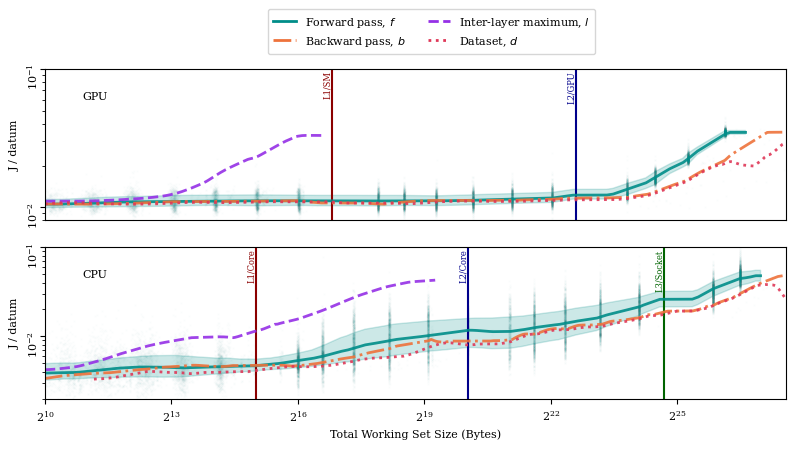

In [6]:
## Plotting function which places the vertical lines for cache levels on an axis

# (line location, color, label)
cache_levels = {
    "cpu": [
        (cpu_level_1_bytes_per_core, cache_colors[0], "L1/Core"),
        (
            cpu_level_1_bytes_per_core + cpu_level_2_bytes_per_core,
            cache_colors[1],
            "L2/Core",
        ),
        (
            cpu_level_1_bytes_per_core
            + cpu_level_2_bytes_per_core
            + cpu_level_3_bytes_per_socket,
            cache_colors[2],
            "L3/Socket",
        ),
    ],
    "gpu": [
        (gpu_level_1_bytes_per_sm, cache_colors[0], "L1/SM"),
        (
            gpu_level_1_bytes_per_sm + gpu_level_2_bytes_per_gpu,
            cache_colors[1],
            "L2/GPU",
        ),
    ],
}


def mark_caches(ax, hardware):
    for x, color, label in cache_levels[hardware]:
        ax.axvline(x=x, color=color)
        ax.text(
            x,
            0.99,
            label,
            color=color,
            ha="right",
            va="top",
            size=6,
            rotation=90,
            transform=ax.get_xaxis_transform(),
        )


## Plotting function which places the plot for one working set on an axis


def working_set_plot(
    x,
    y,
    mark_caches=None,
    ylim=None,
    window_size=1,
    facet="dataset",
    facets=None,
    ax=None,
    color=None,
    lw=1,
    style=None,
    show_scatter=False,
    show_quantiles=False,
    label=None,
):
    if ax == None:
        ax = plt.gca()

    d = pd.DataFrame({"x": np.log2(x), "y": y})
    d.sort_values("x", inplace=True)

    if show_scatter:
        ax.scatter(2 ** d["x"], 10 ** d["y"], marker=".", color=color, alpha=0.02, s=1)

    def compute_quantiles(x_value, s):
        deltas = np.abs(s["x"] - float(x_value))
        window_mask = deltas <= window_size
        window = s.loc[window_mask, "y"].to_numpy()
        if len(window) < 100:
            return np.array([np.nan] * 4)
        v = [x_value] + np.quantile(window, [0.25, 0.5, 0.75]).tolist()
        return v

    interpolation_stepsize = 0.01
    x = np.arange(d["x"].min(), d["x"].max(), interpolation_stepsize)
    quantile_data = [
        value
        for value in (compute_quantiles(x_value, d) for x_value in x)
        if not pd.isna(value[0])
    ]
    quantiles = np.fromiter(
        quantile_data,
        dtype=np.dtype((np.float32, 4)),
        count=len(quantile_data),
    )
    x = quantiles[:, 0]
    moving_average_window_size = int(np.round(window_size / interpolation_stepsize))

    def compute_ma(x):
        def func(i):
            window = x[
                max(0, i - moving_average_window_size) : min(
                    x.shape[0], i + moving_average_window_size
                )
            ]
            return np.average(window)

        return np.fromiter((func(i) for i in range(x.shape[0])), dtype=np.float32)

    ax.plot(
        2**x,
        10 ** compute_ma(quantiles[:, 2]),
        style,
        color=color,
        lw=lw,
        alpha=0.9,
        label=f"{label}",
    )

    if show_quantiles:
        ax.fill_between(
            2**x,
            10 ** compute_ma(quantiles[:, 1]),
            10 ** compute_ma(quantiles[:, 3]),
            color=color,
            alpha=0.2,
        )

    return d["x"].quantile([0.005, 0.995])


styles = ["-", "-.", "--", ":"]
# colors = [pallette[0][0], pallette[0][2], pallette[0][3], "k"]
colors = [
    working_set_colors[1],
    working_set_colors[2],
    working_set_colors[0],
    working_set_colors[3],
]


#### The Plot

# plt fontsize
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

fig, axs = plt.subplots(2, 1, figsize=(8, 4))

gpu_main_working_set = "fwd_pass_working_set_occupied_size"
gpu_alternate_working_sets = [
    "bwd_pass_working_set_occupied_size",
    "per_layer_interlayer_working_set_max_occupied_size",
    "epoch_working_set_occupied_size",
]

cpu_main_working_set = "fwd_pass_working_set_occupied_size"
cpu_alternate_working_sets = [
    "bwd_pass_working_set_occupied_size",
    "per_layer_interlayer_working_set_max_occupied_size",
    "epoch_working_set_occupied_size",
]

for i, (has_gpu, main_working_set, alternate_working_sets) in enumerate(
    zip(
        [True, False],
        [gpu_main_working_set, cpu_main_working_set],
        [gpu_alternate_working_sets, cpu_alternate_working_sets],
    )
):
    ax = axs[i]
    hardware = "gpu" if has_gpu else "cpu"

    mark_caches(ax, hardware)

    x = experiments.loc[
        experiments["has_gpu"] == has_gpu
    ]  # & (wsexp["depth"] == 2)]  # & (wsexp['dataset'] == 'nursery')]

    ## Plot the main working set with scatter and quartile ranges
    limits = working_set_plot(
        # x[f"{main_working_set}_ws_size"],
        x[f"{main_working_set}"],
        x["log10_energy_per_training_datum"],
        window_size=0.5,
        ax=ax,
        style=styles[0],
        lw=2,
        # color = 'gray' if has_gpu else 'black',
        color=colors[0],
        show_scatter=True,  # Show the scatterplot
        show_quantiles=True,  # Show the quantile band
        label=main_working_set,
    )

    for working_set, style, color in zip(
        alternate_working_sets, styles[1:], colors[1:]
    ):
        working_set_plot(
            # x[f"{working_set}_ws_size"],
            x[f"{working_set}"],
            x["log10_energy_per_training_datum"],
            window_size=0.5,
            ax=ax,
            style=style,
            lw=2,
            # color = 'gray' if has_gpu else 'black',
            # color="black",
            color=color,
            show_scatter=False,  # Show the scatterplot
            show_quantiles=False,  # Show the quantile band
            label=working_set,
        )

    if has_gpu:
        ax.set_ylim(8e-3, 1e-1)
    else:
        ax.set_ylim(2e-3, 1e-1)

    print(limits)

    ax.set_xlim(2 ** limits.iloc[0], 2 ** (2 + limits.iloc[1]))

    ax.set_xlabel("Total Working Set Size (Bytes)")
    ax.set_ylabel("J / datum")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=10)
    ax.tick_params(axis="y", labelrotation=90, pad=0)

    ax.annotate(hardware.upper(), (0.05, 0.8), xycoords="axes fraction")


## Set both x axes to the spanning set of both of them.
for ax in axs:
    ax.set_xlim(
        2**10,
        1.5 * 2**27,
    )

## Hide X Labels in upper plot
axs[0].axes.get_xaxis().set_visible(False)

## Create the legend
handles, labels = axs[0].get_legend_handles_labels()
labels = [
    working_set_labels[1],
    working_set_labels[2],
    working_set_labels[0],
    working_set_labels[3],
]
legend = fig.legend(
    handles,
    labels,
    loc="lower center",
    borderaxespad=0.1,
    bbox_to_anchor=(0.542, 0.99),
    borderpad=0.5,
    ncol=2,
)

for h in legend.legendHandles:
    h.set_alpha(1.0)

plt.tight_layout()
plt.savefig("figures/6_caching_set_size.png", dpi=500, bbox_inches="tight")
plt.show()

# inter-layer is distributed -> total size crosses total cache lines
# pass is replicated -> total size crosses per cache lines
# dataset is distributed -> crosses total cache lines